# Cosmetic Ingredient Analysis Dashboard

This notebook presents a dashboard for analyzing cosmetic product ingredients from Sephora's dataset.
The goal is to understand ingredient similarities, cluster similar products, assess allergen presence,
and visually explore ingredient relationships using machine learning and visualization techniques.


In [2]:
# Data handling and ML
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from collections import Counter

# NLP and visualization
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Interactive plots
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from ipywidgets import interact, widgets
output_notebook()



Loading BokehJS ...

## Load Data

Load processed data including:
- Product information (`cosmetics.csv` and `moisturizers_dry.csv`)
- Precomputed ingredient matrix (`ingredient_matrix.npy`)
- Tokenized ingredient corpus (`corpus.npy`)


In [3]:
df = pd.read_csv('cosmetics.csv')
moisturizers_dry = pd.read_csv("moisturizers_dry.csv")
A = np.load("ingredient_matrix.npy")
corpus = np.load("corpus.npy", allow_pickle=True)
# Create an index mapping for ingredients
ingredient_idx = {token: idx for idx, token in enumerate(np.unique([t for sub in corpus for t in sub]))}
print("Available columns in the DataFrame:", df.columns)
print("Available columns in the DataFrame:", df.columns)

Available columns in the DataFrame: Index(['Label', 'Brand', 'Name', 'Price', 'Rank', 'Ingredients', 'Combination',
       'Dry', 'Normal', 'Oily', 'Sensitive'],
      dtype='object')
Available columns in the DataFrame: Index(['Label', 'Brand', 'Name', 'Price', 'Rank', 'Ingredients', 'Combination',
       'Dry', 'Normal', 'Oily', 'Sensitive'],
      dtype='object')


# FEATURE ENGINEERING
This section creates additional features to enhance the dataset for analysis and modeling.

In [4]:
# Create the 'Ingredient Count' column
df['Ingredient Count'] = df['Ingredients'].apply(lambda x: len(x.split(', ')))  # Count ingredients

# Create additional features
df['Price_per_Ingredient'] = df['Price'] / df['Ingredient Count']
df['Has_Fragrance'] = df['Ingredients'].str.contains('fragrance', case=False).astype(int)
df['Has_Parabens'] = df['Ingredients'].str.contains('paraben', case=False).astype(int)

# Skin type features
skin_type_features = ['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']
features = ['Ingredient Count', 'Price', 'Price_per_Ingredient', 
            'Has_Fragrance', 'Has_Parabens'] + skin_type_features
X = df[features].copy()
y = df['Rank']



# DATA SCALING AND MODEL TRAINING
In this section, we scale the features and train regression models to predict product rankings.

In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Linear Regression Mean Squared Error: {mse:.2f}")

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest Mean Squared Error: {rf_mse:.2f}")

# Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print(f"Cross-validated R2 scores: {scores}")

Linear Regression Mean Squared Error: 0.46
Random Forest Mean Squared Error: 0.50
Cross-validated R2 scores: [-0.03791528 -0.0895201  -0.06520274 -0.01895239 -0.20516544]


#  Polynomial Features and Hyperparameter Tuning
This section explores polynomial features and performs hyperparameter tuning for the Random Forest model.

In [6]:
# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Grid Search for Random Forest
param_grid = {'n_estimators': [50, 100, 200]}
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'n_estimators': [50, 100, 200]})

# Sentiment Analysis of Reviews
This section calculates the sentiment of product reviews, based on the ingredients and by making synthetic review.



In [7]:
# Define a sentiment dictionary for ingredients
ingredient_sentiment = {
    'water': 1,  # Positive
    'fragrance': -1,  # Negative
    'paraben': -1,  # Negative
    'shea butter': 1,  # Positive
    'aloe vera': 1,  # Positive
    # Add more ingredients and their sentiment scores
}

# Function to calculate sentiment based on ingredients
def calculate_sentiment(ingredients):
    sentiment_score = 0
    ingredient_list = ingredients.split(', ')
    for ingredient in ingredient_list:
        ingredient = ingredient.strip().lower()
        sentiment_score += ingredient_sentiment.get(ingredient, 0)  # Default to 0 if not found
    return sentiment_score

# Apply the function to the Ingredients column
df['Sentiment'] = df['Ingredients'].apply(calculate_sentiment)

# Calculate average sentiment score
average_sentiment = df['Sentiment'].mean()
print(f"Average Sentiment Score based on Ingredients: {average_sentiment:.2f}")


Average Sentiment Score based on Ingredients: 0.50


In [8]:
# Create synthetic reviews based on product features
def create_synthetic_review(row):
    review = f"This product is priced at ${row['Price']:.2f} and has a rank of {row['Rank']}."
    if row['Has_Fragrance']:
        review += " It contains fragrance, which may not be suitable for sensitive skin."
    if row['Has_Parabens']:
        review += " It contains parabens, which some users may want to avoid."
    return review

# Apply the function to create synthetic reviews
df['Synthetic_Review'] = df.apply(create_synthetic_review, axis=1)

# Perform sentiment analysis on synthetic reviews
df['Sentiment'] = df['Synthetic_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate average sentiment score
average_sentiment = df['Sentiment'].mean()
print(f"Average Sentiment Score from Synthetic Reviews: {average_sentiment:.2f}")


Average Sentiment Score from Synthetic Reviews: -0.54


# Word Cloud Visualization

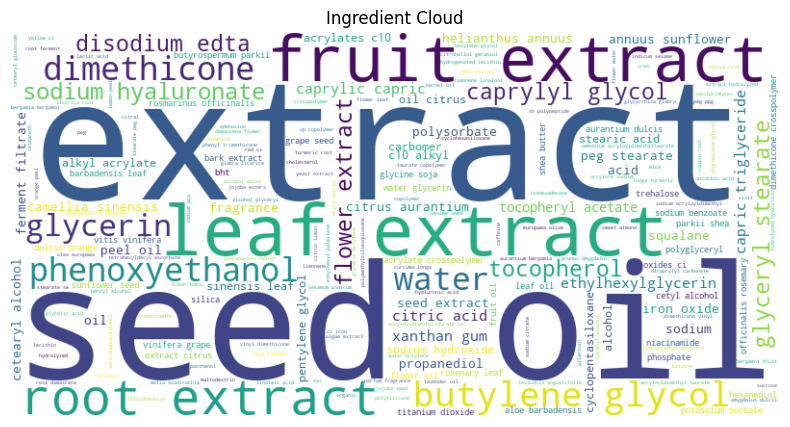

In [9]:
# Load the corpus from the .npy file
corpus = np.load("corpus.npy", allow_pickle=True)

# Flatten the list of ingredients
flat_ingredients = [ingredient for sublist in corpus for ingredient in sublist]

# Generate a word cloud for the most common ingredients
all_ingredients = ' '.join(flat_ingredients)  # Join all ingredients into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Ingredient Cloud")  # Set the title
plt.show()  # Display the word cloud

## Cluster Summary

Summarize clusters:
- Product count per cluster
- Average price per cluster


In [10]:
def clean_ingredients(ingredient_str):
    if pd.isna(ingredient_str): return []
    ingredients = re.split(r',|\s+|\|', ingredient_str.lower())
    return [ing.strip() for ing in ingredients if ing.strip()]

df['ingredients_cleaned'] = df['Ingredients'].apply(clean_ingredients)

vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, binary=True)
ingredient_matrix = vectorizer.fit_transform(df['ingredients_cleaned']).toarray()
ingredient_df = pd.DataFrame(ingredient_matrix, columns=vectorizer.get_feature_names_out())


C:\Users\sree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
if 'Cluster' in moisturizers_dry.columns:
    cluster_summary = moisturizers_dry.groupby('Cluster').agg({
        'Name': 'count',
        'Price': 'mean'
    }).rename(columns={'Name': 'Product Count', 'Price': 'Avg Price'})
    print("\n Cluster Summary:\n")
    print(cluster_summary)


## Ingredient Statistics

- Top 15 most common ingredients across all products
- Price distribution
- Ingredient count per product
- Ingredient count vs. product price


In [12]:
def cluster_ingredients(cluster_id):
    indices = moisturizers_dry[moisturizers_dry['Cluster'] == cluster_id].index
    ing_list = [ing for idx in indices for ing in corpus[idx]]
    counter = Counter(ing_list)
    print(f"\nTop Ingredients in Cluster {cluster_id}:")
    for ing, count in counter.most_common(10):
        print(f"{ing}: {count}")
    
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(ingredient_df)

   # Copy the 'Cluster' column to moisturizers_dry
moisturizers_dry['Cluster'] = df['Cluster']
   
# Check if the 'Cluster' column is added
print(df.columns)  # This should include 'Cluster'
       
# Analyze specific clusters
cluster_ingredients(1)
cluster_ingredients(3)

Index(['Label', 'Brand', 'Name', 'Price', 'Rank', 'Ingredients', 'Combination',
       'Dry', 'Normal', 'Oily', 'Sensitive', 'Ingredient Count',
       'Price_per_Ingredient', 'Has_Fragrance', 'Has_Parabens', 'Sentiment',
       'Synthetic_Review', 'ingredients_cleaned', 'Cluster'],
      dtype='object')

Top Ingredients in Cluster 1:
phenoxyethanol: 37
water: 36
glycerin: 35
butylene glycol: 28
dimethicone: 22
disodium edta: 21
xanthan gum: 20
caprylyl glycol: 20
tocopherol: 17
citric acid: 17

Top Ingredients in Cluster 3:
water: 2
stearic acid: 2
glyceryl stearate: 2
dimethicone: 2
caprylyl glycol: 2
disodium edta: 2
xanthan gum: 2
glycerin: 1
c12-15 alkyl benzoate: 1
caprylic/capric triglyceride: 1


## Cluster-wise Product Statistics

This section visualizes basic statistics for each product cluster:
- **Product Count per Cluster**: How many products are grouped into each cluster based on ingredient similarity.
- **Average Price per Cluster**: The average product price within each cluster, giving insight into cost trends across clusters.



 Cluster Summary Statistics:
         Product_Count  Avg_Price
Cluster                          
0                    8  80.500000
1                   57  65.894737
2                   11  82.909091
3                    4  47.250000
4                  110  71.172727


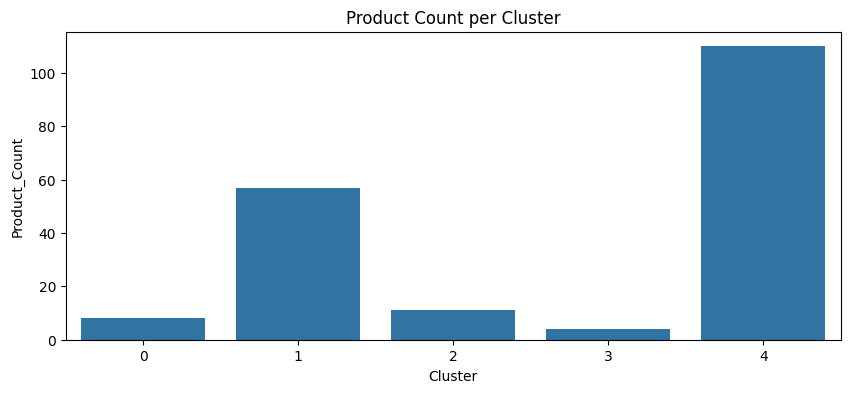

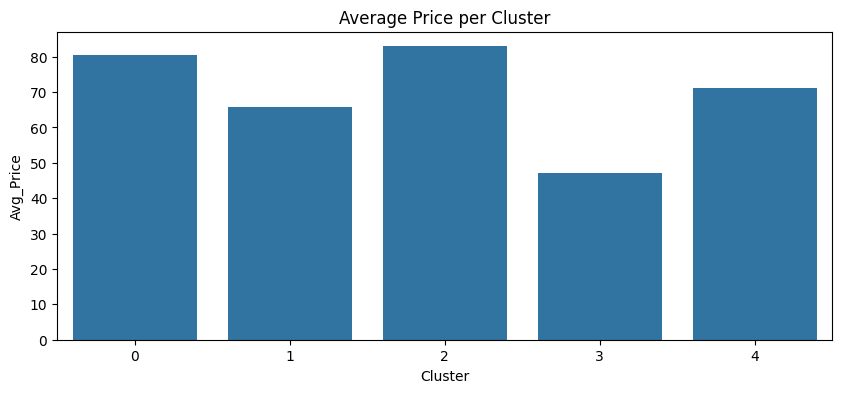

In [14]:
# Summarize clusters by product count and average price
if 'Cluster' in moisturizers_dry.columns:
    cluster_summary = moisturizers_dry.groupby('Cluster').agg(
        Product_Count=('Name', 'count'),
        Avg_Price=('Price', 'mean')
    ).sort_index()
 
    print("\n Cluster Summary Statistics:")
    print(cluster_summary)

    # Product count
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_summary.index, y=cluster_summary['Product_Count'])
    plt.title("Product Count per Cluster")
    plt.show()

    # Average price
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_summary.index, y=cluster_summary['Avg_Price'])
    plt.title("Average Price per Cluster")
    plt.show()
else:
    print("Cannot generate summary. 'Cluster' column missing.")


## Ingredient and Price Analysis

This section provides a deeper look into product formulation and pricing:

- **Top 15 Most Common Ingredients**: A bar chart showing the most frequently used ingredients across all moisturizer products for dry skin.
- **Price Distribution**: A histogram to show how product prices are distributed in the dataset.
- **Ingredient Count per Product**: Visualizes how many ingredients each product typically contains.
- **Ingredient Count vs. Price**: A scatter plot examining the relationship between number of ingredients and product price — helpful for identifying whether more complex formulations tend to cost more.


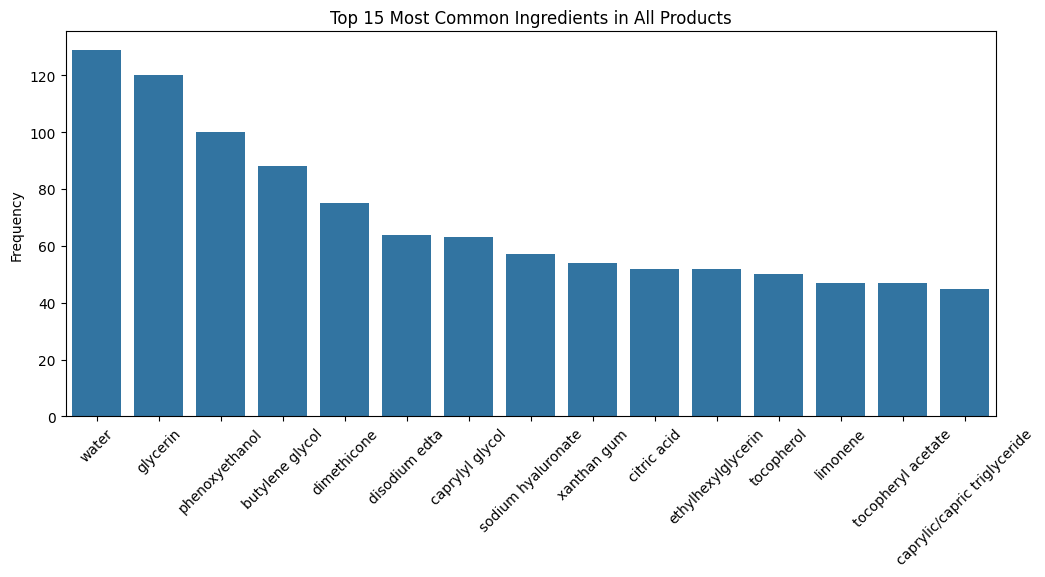

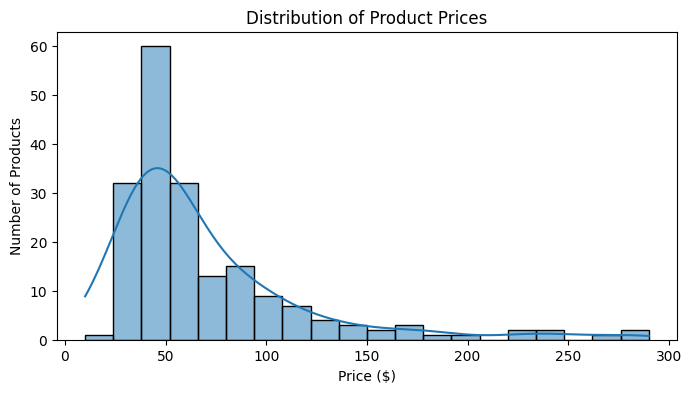

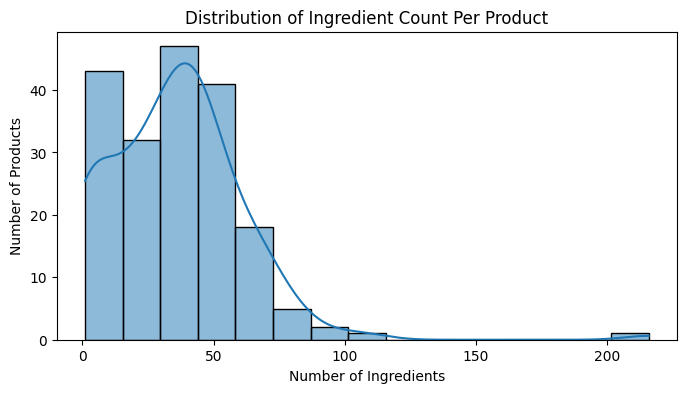

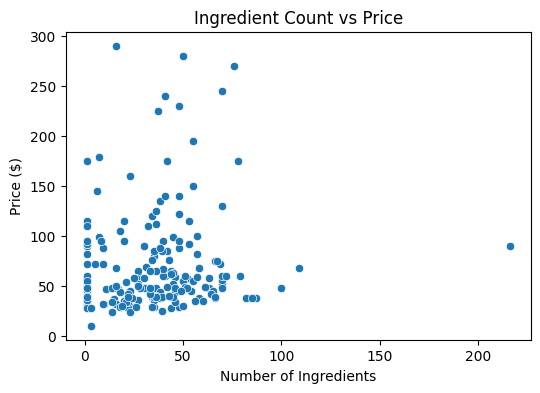

In [15]:
# Top 15 ingredients
top_ingredients = Counter([ing for sub in corpus for ing in sub])
top_15 = top_ingredients.most_common(15)
ing_names, ing_counts = zip(*top_15)

plt.figure(figsize=(12,5))
sns.barplot(x=list(ing_names), y=list(ing_counts))
plt.xticks(rotation=45)
plt.title("Top 15 Most Common Ingredients in All Products")
plt.ylabel("Frequency")
plt.show()

# Price distribution
plt.figure(figsize=(8,4))
sns.histplot(moisturizers_dry['Price'], bins=20, kde=True)
plt.title("Distribution of Product Prices")
plt.xlabel("Price ($)")
plt.ylabel("Number of Products")
plt.show()

# Ingredient count per product
moisturizers_dry['Ingredient Count'] = [len(i) for i in corpus]
plt.figure(figsize=(8,4))
sns.histplot(moisturizers_dry['Ingredient Count'], bins=15, kde=True)
plt.title("Distribution of Ingredient Count Per Product")
plt.xlabel("Number of Ingredients")
plt.ylabel("Number of Products")
plt.show()

# Scatter: Ingredient count vs Price
plt.figure(figsize=(6,4))
sns.scatterplot(x='Ingredient Count', y='Price', data=moisturizers_dry)
plt.title("Ingredient Count vs Price")
plt.xlabel("Number of Ingredients")
plt.ylabel("Price ($)")
plt.show()


## Ingredient Cleaning and Vectorization

To prepare the ingredient data for machine learning:

**Text Preprocessing**: Ingredients are cleaned by:
   Lowercasing all text
   Splitting based on commas, spaces, or pipe symbols
   Removing extra whitespace or empty tokens

**Vectorization**:
   The cleaned ingredient lists are transformed into a **binary document-term matrix** using `CountVectorizer`.
   Each row represents a product and each column represents a unique ingredient.
   A value of `1` indicates the presence of an ingredient in a product.

This binary matrix serves as input for clustering and dimensionality reduction in the next steps.


In [16]:
def clean_ingredients(ingredient_str):
    if pd.isna(ingredient_str): return []
    ingredients = re.split(r',|\s+|\|', ingredient_str.lower())
    return [ing.strip() for ing in ingredients if ing.strip()]

df['ingredients_cleaned'] = df['Ingredients'].apply(clean_ingredients)

vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, binary=True)
ingredient_matrix = vectorizer.fit_transform(df['ingredients_cleaned']).toarray()
ingredient_df = pd.DataFrame(ingredient_matrix, columns=vectorizer.get_feature_names_out())


C:\Users\sree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Dimensionality Reduction and Clustering

To explore ingredient-based product similarity we are using,

**t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
   To reduce high-dimensional binary ingredient vectors into 2D space for   visualization.
   It preserves local structure and clusters similar products closer together.

**K-Means Clustering**:
   To group products into 5 distinct clusters based on ingredient composition.
   Each of these clusters represents a common formulation pattern or product type.

**Visualization**:
   A 2D scatter plot is used to show the clustering result.
   Points are colored by cluster to highlight formulation groups.


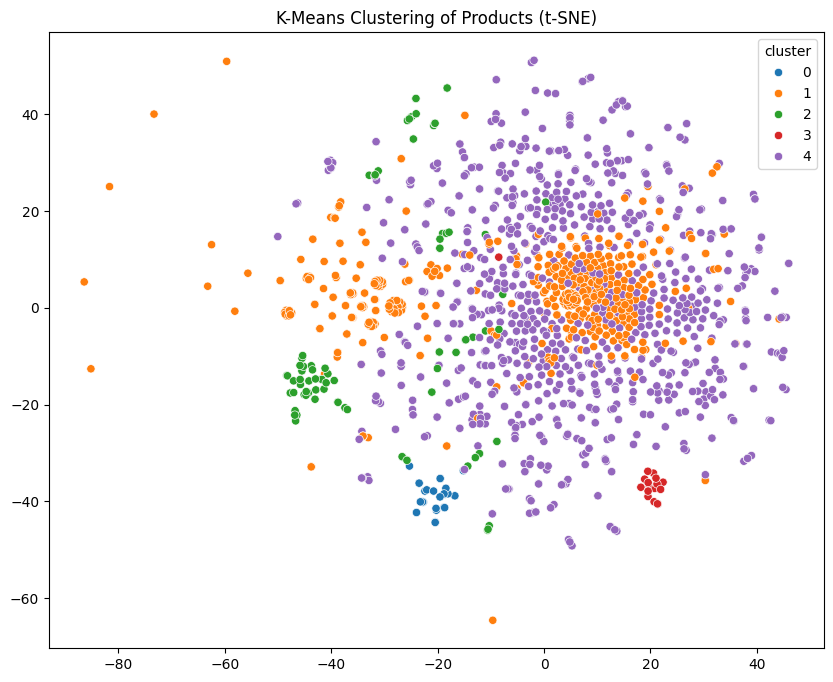

In [17]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
ingredient_tsne = tsne.fit_transform(ingredient_df)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(ingredient_df)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=ingredient_tsne[:, 0], y=ingredient_tsne[:, 1], hue=df['cluster'], palette="tab10")
plt.title("K-Means Clustering of Products (t-SNE)")
plt.show()


## Interactive Bokeh Visualization

This section creates an interactive visualization of the t-SNE scatter plot of products.
 - Points are colored by cluster using the `Category10` palette.
 - Hover shows brand, ingredients, and cluster.


In [18]:
from bokeh.palettes import Category10

# Map clusters to colors
num_clusters = df['cluster'].nunique()
palette = Category10[10]  # Works up to 10 clusters
colors = [palette[c % 10] for c in df['cluster']]

# Update source with mapped color
source = ColumnDataSource(data={
    'x': ingredient_tsne[:, 0],
    'y': ingredient_tsne[:, 1],
    'product': df['Brand'],
    'ingredients': df['Ingredients'],
    'cluster': df['cluster'],
    'color': colors
})

# Plot with explicit colors
p = figure(width=800, height=600, title="Cosmetic Ingredient Clustering", tools="pan,wheel_zoom,reset")
p.scatter('x', 'y', source=source, size=8, color='color', alpha=0.7, line_color=None)

# Hover tool
hover = HoverTool(tooltips=[
    ("Product", "@product"),
    ("Ingredients", "@ingredients"),
    ("Cluster", "@cluster")
])
p.add_tools(hover)

show(p)


## Allergen Analysis

Checking for the presence of known allergens:
- Fragrance
- Parabens
- Sulfates
- Phthalates
- Formaldehyde


In [19]:
allergens = ['fragrance', 'parabens', 'sulfates', 'phthalates', 'formaldehyde']
for allergen in allergens:
    df[f'contains_{allergen}'] = df['Ingredients'].str.lower().str.contains(allergen, na=False)

allergen_summary = df[[f'contains_{allergen}' for allergen in allergens]].sum().sort_values(ascending=False)
print("\nAllergen Prevalence:")
print(allergen_summary)



Allergen Prevalence:
contains_fragrance       502
contains_parabens          2
contains_phthalates        2
contains_sulfates          0
contains_formaldehyde      0
dtype: int64



--- Allergen Prevalence (All Products) ---

Allergen Prevalence (Percentage of Products Containing):

- Alcohol: 45.38%
- Fragrance: 34.10%
- Parabens: 0.14%
- Phthalates: 0.14%
- Sulfates: 0.00%
- Formaldehyde: 0.00%


C:\Users\sree\AppData\Local\Temp\ipykernel_14432\2665441718.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=allergen_percentage.index.str.replace('contains_', '').str.replace('_', ' ').str.title(),


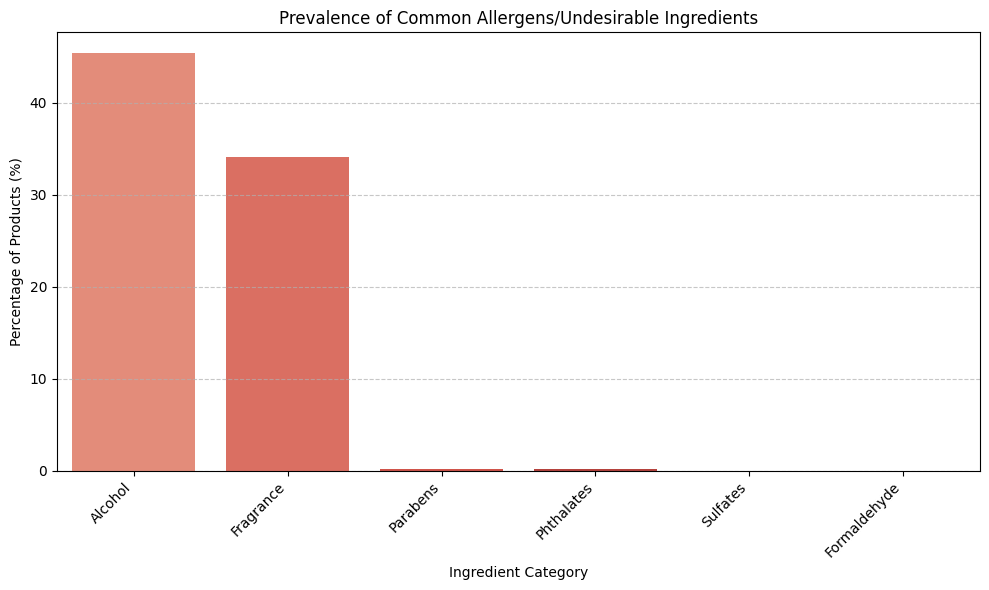

In [20]:
print("\n--- Allergen Prevalence (All Products) ---")
allergens = ['fragrance', 'parabens', 'sulfates', 'phthalates', 'formaldehyde', 'alcohol']
for allergen in allergens:
    df[f'contains_{allergen}'] = df['Ingredients'].str.lower().str.contains(allergen, na=False)

allergen_summary = df[[f'contains_{allergen}' for allergen in allergens]].sum().sort_values(ascending=False)
total_products = len(df)
allergen_percentage = (allergen_summary / total_products * 100).round(2)

print("\nAllergen Prevalence (Percentage of Products Containing):\n")
for allergen, percent in allergen_percentage.items():
    print(f"- {allergen.replace('contains_', '').replace('_', ' ').title()}: {percent:.2f}%")

# Visualize allergen prevalence
plt.figure(figsize=(10, 6))
sns.barplot(x=allergen_percentage.index.str.replace('contains_', '').str.replace('_', ' ').str.title(),
            y=allergen_percentage.values, palette='Reds_d')
plt.title("Prevalence of Common Allergens/Undesirable Ingredients")
plt.xlabel("Ingredient Category")
plt.ylabel("Percentage of Products (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# TOP PRODUCTS

# Best products based on the clusters

In [21]:
# List of skin types in the dataset
skin_types = ['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']

# Initialize a dictionary to hold top products
top_products = {}

# Loop through each cluster
for cluster_id in sorted(df['Cluster'].unique()):
    print(f"\nCluster {cluster_id}:")

    cluster_df = df[df['Cluster'] == cluster_id]
    top_products[cluster_id] = {}

    # Loop through each skin type
    for skin_type in skin_types:
        # Filter products suitable for this skin type
        suitable_products = cluster_df[cluster_df[skin_type] == 1]

        if not suitable_products.empty:
            # Get the product with the highest rank (assuming higher is better)
            top_product = suitable_products.sort_values(by='Rank', ascending=False).iloc[0]

            print(f"  {skin_type} Skin → {top_product['Brand']} - {top_product['Name']} | Rank: {top_product['Rank']}, Price: ${top_product['Price']}")
            top_products[cluster_id][skin_type] = top_product['Name']
        else:
            print(f"  {skin_type} Skin → No suitable product found.")
            top_products[cluster_id][skin_type] = None



Cluster 0:
  Combination Skin → LA MER - The Perfecting Treatment | Rank: 4.6, Price: $245
  Dry Skin → LA MER - The Perfecting Treatment | Rank: 4.6, Price: $245
  Normal Skin → LA MER - The Perfecting Treatment | Rank: 4.6, Price: $245
  Oily Skin → LA MER - The Perfecting Treatment | Rank: 4.6, Price: $245
  Sensitive Skin → LA MER - The Perfecting Treatment | Rank: 4.6, Price: $245

Cluster 1:
  Combination Skin → COOLA - Sport Continuous Spray SPF 30 - Unscented | Rank: 5.0, Price: $32
  Dry Skin → COOLA - Sport Continuous Spray SPF 30 - Unscented | Rank: 5.0, Price: $32
  Normal Skin → COOLA - Sport Continuous Spray SPF 30 - Unscented | Rank: 5.0, Price: $32
  Oily Skin → KIEHL'S SINCE 1851 - Epidermal Re-Texturizing Micro-Dermabrasion | Rank: 5.0, Price: $41
  Sensitive Skin → COOLA - Sport Continuous Spray SPF 30 - Unscented | Rank: 5.0, Price: $32

Cluster 2:
  Combination Skin → CLINIQUE - Limited Edition Dramatically Different™ Moisturizing Gel | Rank: 5.0, Price: $39
  Dry

# Best product found for any combiation required by user

In [22]:
def get_top_products(df, skin_type, cluster=None, max_price=None):
    
    if skin_type not in ['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']:
        raise ValueError(f"Invalid skin type: {skin_type}")
    # convert Rank to numeric
    df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')
    df = df.dropna(subset=['Rank'])
    # filter by skin type
    filtered = df[df[skin_type] == 1]
    # filter by cluster
    if cluster is not None and 'Cluster' in df.columns:
        filtered = filtered[filtered['Cluster'] == cluster]
    # filter by max price
    if max_price is not None:
        filtered = filtered[filtered['Price'] <= max_price]
    # Sort by Rank and Price to get best product
    if not filtered.empty:
        top_product = filtered.sort_values(by=['Rank', 'Price']).head(1)
        return top_product[['Brand', 'Name', 'Price', 'Rank', 'Cluster', 'Ingredients']].reset_index(drop=True)
    else:
        return pd.DataFrame([{'Brand': 'N/A', 'Name': 'No suitable product', 'Price': None, 'Rank': None, 'Cluster': cluster, 'Ingredients': 'N/A'}])


# 1. By skin type
print("\n Best for Dry Skin:")
print(get_top_products(moisturizers_dry, skin_type='Dry').to_string(index=False))

# 2. Skin type + Cluster 0
print("\n Best for Oily Skin in Cluster 0:")
print(get_top_products(moisturizers_dry, skin_type='Oily', cluster=0).to_string(index=False))

# 3. Skin type + Max price
print("\n Best for Sensitive Skin under $20:")
print(get_top_products(moisturizers_dry, skin_type='Sensitive', max_price=20).to_string(index=False))

# 4. Skin type + Cluster + Max price
print("\n Best for Normal Skin in Cluster 2 under $30:")
print(get_top_products(moisturizers_dry, skin_type='Normal', cluster=2, max_price=30).to_string(index=False))




 Best for Dry Skin:
   Brand                                                         Name  Price  Rank  Cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Ingredients
CLINIQUE Limited Edition Dramatically Different Moisturizing Lotion+™     39   0.0        4 Water, Mineral Oil/Paraffinum Liquidum/Huile Minerale, Glycerin, Petrolatum, Stearic Acid, Glyceryl Stearate, Sesamum Indicum (Sesame) Oil, Urea, Lanolin Alcohol, Triethanolamine, Hordeum Vulgare (Barley) Extract/Extrait D'Orge, Cucumis Sativus (Cucumber) Fruit Extract, Helianthus Annuus (Sunflower) Seedcak

# Overall TOP product for DRY skin

In [23]:
# Filter only products suitable for dry skin
dry_products = moisturizers_dry[moisturizers_dry['Dry'] == 1]

# Sort by Rank, then Price to resolve ties
top_dry_product = dry_products.sort_values(by=['Rank', 'Price']).head(1)

# Display result
print("💧 Top-Rated Product for Dry Skin Overall:")
print(top_dry_product[['Brand', 'Name', 'Price', 'Rank', 'Ingredients']].to_string(index=False))

💧 Top-Rated Product for Dry Skin Overall:
   Brand                                                         Name  Price  Rank                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Ingredients
CLINIQUE Limited Edition Dramatically Different Moisturizing Lotion+™     39   0.0 Water, Mineral Oil/Paraffinum Liquidum/Huile Minerale, Glycerin, Petrolatum, Stearic Acid, Glyceryl Stearate, Sesamum Indicum (Sesame) Oil, Urea, Lanolin Alcohol, Triethanolamine, Hordeum Vulgare (Barley) Extract/Extrait D'Orge, Cucumis Sativus (Cucumber) Fruit Extract, Helianthus Annuus (Sunflower) Seed

## Final Report Generation

This creates a markdown summary with:
- Total products analyzed
- Top 5 most frequent ingredients
- Allergen occurrence
- Number of distinct ingredient clusters


In [27]:
# Calculate additional statistics
average_price = df['Price'].mean()
min_price = df['Price'].min()
max_price = df['Price'].max()
median_price = df['Price'].median()

ingredient_count_stats = df['Ingredient Count'].describe()

# Count products suitable for each skin type
skin_type_counts = {skin_type: df[skin_type].sum() for skin_type in skin_type_features}

# Top 5 clusters by product count
top_clusters = df['Cluster'].value_counts().head(5)

# Get the top 5 ingredients from the Counter object
top_ingredients = Counter([ing for sublist in corpus for ing in sublist])
top_5_ingredients = [ingredient for ingredient, count in top_ingredients.most_common(5)]

# Prepare the report
report = f"""
# Cosmetic Ingredient Analysis Report

1. **Total Products Analyzed**: {len(df)}
2. **Average Price of Products**: ${average_price:.2f}
3. **Price Distribution**:
   - Minimum Price: ${min_price:.2f}
   - Maximum Price: ${max_price:.2f}
   - Median Price: ${median_price:.2f}
4. **Top 5 Ingredients**: {top_5_ingredients}
5. **Ingredient Count Statistics**:
   - Average Ingredient Count: {ingredient_count_stats['mean']:.2f}
   - Minimum Ingredient Count: {ingredient_count_stats['min']}
   - Maximum Ingredient Count: {ingredient_count_stats['max']}
6. **Allergen Prevalence**:
   - Fragrance: {allergen_summary['contains_fragrance']} products
   - Parabens: {allergen_summary['contains_parabens']} products
7. **Clusters**: {df['Cluster'].nunique()} distinct ingredient groups.
8. **Top 5 Clusters by Product Count**: {top_clusters.index.tolist()}
9. **Skin Type Suitability**:
   - Combination: {skin_type_counts['Combination']}
   - Dry: {skin_type_counts['Dry']}
   - Normal: {skin_type_counts['Normal']}
   - Oily: {skin_type_counts['Oily']}
   - Sensitive: {skin_type_counts['Sensitive']}
10. **Average Sentiment Score from Synthetic Reviews**: {average_sentiment:.2f}
"""

# Save the report to a Markdown file
with open("cosmetic_analysis.md", "w") as f:
    f.write(report)

print("Report generated successfully!")


Report generated successfully!
